### Bouc Wen Model for Material Plasticity

The Bouc-Wen (B-W) model is widely employed to describe the hysteretic behaviour of mechanical systems.
It has been used in the structural dynamics community to describe the cyclic behaviour of joints and the macro-scale deformation behaviour of nonlinear isolators.
It has also been adapted to describe the plastic behaviour of metallic materials under cyclic loading.  
The generalised stress-strain relation using Bouc-Wen is given as 

$$
\begin{aligned}
d\boldsymbol{\sigma} = f(\boldsymbol{\varepsilon}, \boldsymbol{z}) = \alpha E d\boldsymbol{\varepsilon} + (1-\alpha) E d\boldsymbol{z}
\end{aligned}
$$

where $\boldsymbol{\sigma}$ is stress; $\boldsymbol{\varepsilon}$ is strain; $E$ is elastic young modulus; $\alpha$ is the ratio of post-yield to initial elastic modulus; and $\boldsymbol{z}$ is the internal (or hidden) state variable that captures the history dependency or hysteretic behaviour.
In this work, $d$ is used as a differentiation operator unless otherwise assigned. 
B-W model describes the internal state variable using the following differential equation:

$$
\begin{aligned}
\frac{d\boldsymbol{z}}{d \boldsymbol{\varepsilon}} = g(\boldsymbol{\varepsilon}, \boldsymbol{z}) = \left( 1-\lvert\frac{\boldsymbol{z}}{ \varepsilon_y}\lvert^n \left[\beta+\gamma \text{sign}(\boldsymbol{z} d \boldsymbol{\varepsilon}) \right] \right)
\end{aligned}
$$

where $\varepsilon_y$ is the initial yield strain. 
Parameter $n$ controls the smoothness of the transition from the elastic to the inelastic regime, while the terms $\beta$ and $\gamma$ introduced in this equation are shape factors that affect the shape of the hysteresis loop.
The equation above is a time-independent expression that is used to formulate the kinematic hardening of material systems.

The above equations can be combined as follows

$$
d\boldsymbol{\sigma} = f(\boldsymbol{\varepsilon}, \boldsymbol{z}) = \left(\alpha E  + (1-\alpha) E \frac{d\boldsymbol{z}}{d\boldsymbol{\varepsilon}} \right) d\boldsymbol{\varepsilon}, \\
d\boldsymbol{\sigma} = f(\boldsymbol{\varepsilon}, \boldsymbol{z}) = \left(\alpha E  + (1-\alpha) E \left( 1-\lvert\frac{\boldsymbol{z}}{ \varepsilon_y}\lvert^n \left[\beta+\gamma \text{sign}(\boldsymbol{z} d \boldsymbol{\varepsilon}) \right] \right) \right) d\boldsymbol{\varepsilon} \\
$$

if we take $\frac{d\boldsymbol{z}}{d\boldsymbol{\varepsilon}} =h$ : 

$$
d\boldsymbol{\sigma} = f(h) d\boldsymbol{\varepsilon} = \left(\alpha E  + (1-\alpha) E h \right) d\boldsymbol{\varepsilon} \\
$$

In [2]:
# BW model with torchdyn ode solver (FINAL)
import numpy as np
import torch
import torch.nn as nn
from torchdyn.numerics import odeint, Euler, HyperEuler
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# from ipywidgets import interact
# %matplotlib qt
# import pyqtgraph as pg
# from pyqtgraph.Qt import QtGui
# plt.rcdefaults()

# figure styling
font=18
font_axis=20
plt.rcParams.update({'font.size': font})  # Set the desired font size
# plt.rcParams['text.usetex'] = True
# plt.rcParams['figure.facecolor'] = 'white'  # Background color for figures
# plt.rcParams['axes.facecolor'] = 'white'    # Background color for axes
# Set the font to Times New Roman globally
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "stix"  # Use a math font for mathtext (like Greek symbols)

import multiprocessing as mp
import sys
import os
# quick run for automated notebook validation
# dry_run = False

In [ ]:
# Strain path generation
def deformation(M, tmax, Fmax, Fscale, steps):

    t_interp = np.linspace(0, tmax, steps)
    seed=None

    if seed is not None:
        np.random.seed(seed)
        
    # Divide time interval [0, 1] into M intervals
    t = np.sort(np.random.uniform(0, 1, M))
    t = np.insert(t, 0, 0)  # Ensure t^0 = 0
    t = np.append(t, 1)      # Ensure t^M = 1

    # Initialize F_ij arrays (for i,j=1:3)
    F = np.zeros((M + 2))

    # Initialize velocity increments
    v = np.random.choice([-1, 1], size=(M + 1))  # v_ij are Rademacher variables


    for m in range(1, M + 2):
        delta_t = np.sqrt(t[m] - t[m - 1])
        F[m] = F[ m - 1] + v[m - 1] * Fmax * delta_t

    # Create interpolated paths for F_ij(t)
    interpolated_F = {}


    # Cubic Hermite spline interpolation
    spline = CubicHermiteSpline(t, F, np.gradient(F, t))
    interpolated_F = spline
    derivative_F = spline.derivative(nu=1)
    
    # Interpolate the values
    F_interp = interpolated_F(t_interp)
    F_prim = derivative_F(t_interp)

    max_value =np.max(np.abs(F_interp))
    F_interp = F_interp / max_value
    F_interp = F_interp * Fscale

    F_prim = F_prim / max_value
    F_prim = F_prim * Fscale

    return t_interp, F_interp, F_prim, t, (F / max_value) * Fscale

In [4]:


class BoucWen(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
    
    def forward(self, state, dx):
        # Get parameters from self.params
        beta = self.params['beta']
        gamma = self.params['gamma']
        zy = self.params['zy']
        n = self.params['n']
        alpha = self.params['alpha']
        k = self.params['k']
        
        z, S, Sel, Snl = state

        # Compute dz using Bouc-Wen equation
        dz = (dx) * (1 - (torch.abs(z/zy)**n) * (gamma + beta * torch.sign(dx*z))) 
        ds_el = alpha * k * dx
        ds_nl = (1-alpha) * k * dz
        ds = alpha * k * dx + (1-alpha) * k * dz  
        out = torch.stack([dz, ds, ds_el, ds_nl])
        return out
    
def update_state(dx, z0, params):
    t_span = torch.tensor([0, 1], dtype=torch.float32)
    
    # Create the Bouc-Wen system with params
    system = BoucWen(params)
    z0=torch.tensor(z0)
    
    # Create neural ODE (note: removed args parameter)
    t, sol = odeint(lambda t, z: system(z,dx), z0, t_span, solver='tsit5') # euler, rk4, dopri5, tsit5 (, atol=1e-3, rtol=1e-3)
    
    return sol[-1]  # Return only the final state


def append_or_save(file_path, new_data):
    if os.path.exists(file_path):
        existing_data = np.load(file_path)
        new_data = np.expand_dims(new_data, axis=0)
        combined_data = np.concatenate((existing_data, new_data), axis=0)
        np.save(file_path, combined_data)
    else:
        # If the file doesn't exist, expand dims and save
        new_data = np.expand_dims(new_data, axis=0)
        np.save(file_path, new_data)

# Example usage
if __name__ == "__main__":
    # Generate sample discrete data
    file_t_point = 't_point.npy'
    file_strain_point = 'strain_point.npy'
    file_t = 't.npy'
    file_strain = 'strain.npy'
    file_dstrain = 'dstrain.npy'
    file_state = 'state.npy'
    file_S = 'S.npy'
    file_Sel = 'Sel.npy'
    file_Snl = 'Snl.npy'

    for i in range(1):
        # Set parameters
        M = 12
        Fmax = 1.0
        Fscale=0.02
        tmax=1
        steps=200
        t, strain, dstrain, t_point, strain_point = deformation(M, tmax, Fmax, Fscale, steps)
        strain_tensor = torch.tensor(strain)
        # Generate sample discrete data
        # t = torch.linspace(0, 10, 2000)
        # strain = Fscale * torch.sin(2*torch.pi*t)
    
        # Storage for results
        results = {
            'strain':  strain_tensor,
            'z': torch.zeros_like(strain_tensor),
            'S': torch.zeros_like(strain_tensor),
            'Sel': torch.zeros_like(strain_tensor),
            'Snl': torch.zeros_like(strain_tensor),
        }
    
        # Simulate the cycles
        for i in range(1, len(strain_tensor)):
            strain_increment = strain_tensor[i] - strain_tensor[i-1]
            # Bouc-Wen parameters
            params = {
                'beta': 0.5,
                'gamma': 0.5,
                'n': 1.0,
                'zy': 8e-4,
                'alpha': 0.05,
                'k': 200e9,
            }
            input = [results['z'][i-1], results['S'][i-1], results['Sel'][i-1], results['Snl'][i-1]]
            state = update_state(strain_increment, input, params)
            results['z'][i] = state[0]
            results['S'][i] = state[1]
            results['Sel'][i] = state[2]
            results['Snl'][i] = state[3]

        S = results['S']
        Sel = results['Sel']
        Snl = results['Snl']

        # append_or_save(file_t_point, t_point)
        # append_or_save(file_strain_point, strain_point)
        # append_or_save(file_dstrain, dstrain)

        # append_or_save(file_t, t)
        # append_or_save(file_strain, strain)
        # append_or_save(file_state, results['z'])

        # append_or_save(file_S, S)
        # append_or_save(file_Sel, Sel)
        # append_or_save(file_Snl, Snl)

    print('Yielding point (MPa)')
    print((params['k'] * params['zy']) /1e6)



Yielding point (MPa)
160.0


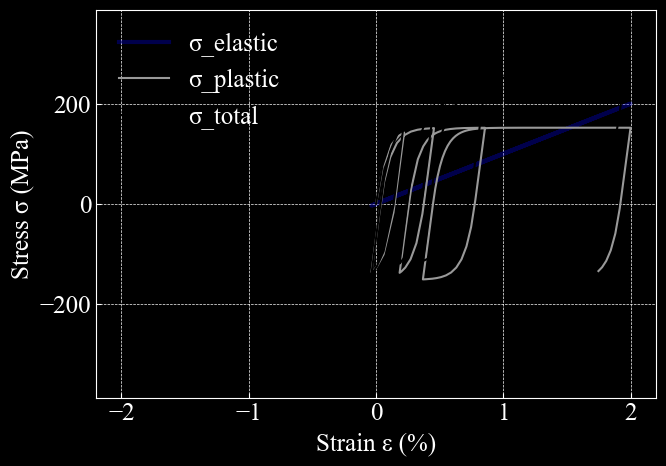

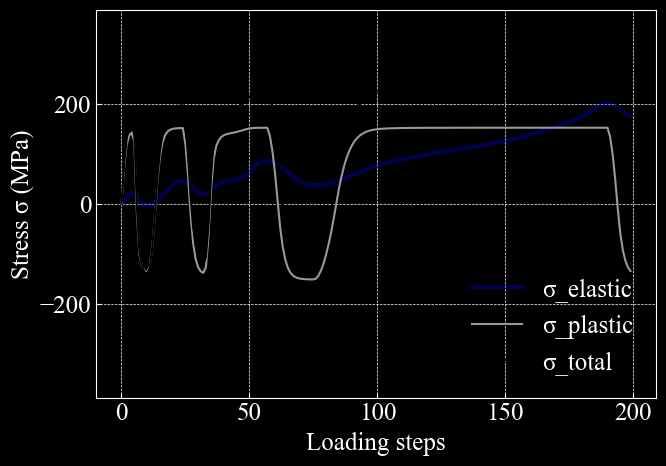

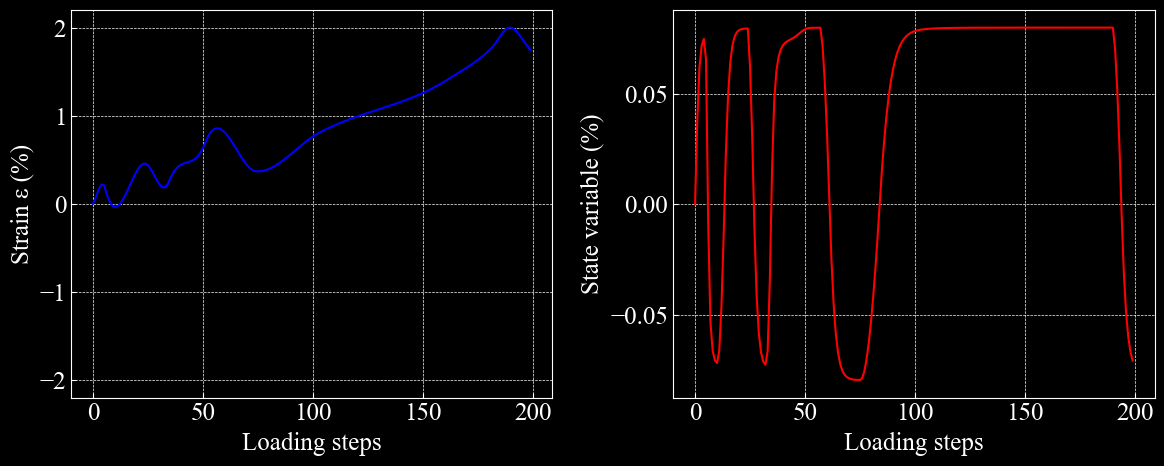

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(strain*100, Sel/1e6, color='blue', alpha=0.3, linewidth=3, label="σ_elastic")
plt.plot(strain*100, Snl/1e6, color=[0.6, 0.6, 0.6], label="σ_plastic")
plt.plot(strain*100, S/1e6, color=[0, 0, 0], label="σ_total")
Ylim=torch.max(torch.abs(S/1e6)) + torch.max(torch.abs(S/1e6))*0.1
plt.ylim(-Ylim, Ylim)
xlim=np.max(np.abs(strain*100)) + np.max(np.abs(strain*100))*0.1
plt.xlim(-xlim, xlim)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Strain ε (%)")
plt.ylabel("Stress σ (MPa)")
plt.tick_params(direction='in')
plt.tight_layout()
plt.legend(frameon=False)# prop={'family': 'Times New Roman', 'size': 14},loc='upper right',
plt.show()

plt.figure(figsize=(7, 5))    
plt.plot(Sel/1e6, color='blue', alpha=0.3, linewidth=3, label="σ_elastic")
plt.plot(Snl/1e6,  color=[0.6, 0.6, 0.6], label="σ_plastic")
plt.plot(S/1e6,  color=[0, 0, 0], label="σ_total")
Ylim=torch.max(torch.abs(S/1e6)) + torch.max(torch.abs(S/1e6))*0.1
plt.ylim(-Ylim, Ylim)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Loading steps")
plt.ylabel("Stress σ (MPa)")
plt.tick_params(direction='in')
plt.tight_layout()
plt.legend(frameon=False)# prop={'family': 'Times New Roman', 'size': 14},loc='upper right',
plt.show()

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# First subplot: Strain
axes[0].plot(strain*100, 'b', label="strain")
axes[0].set_xlabel("Loading steps")
axes[0].set_ylabel("Strain ε (%)")
ylim=np.max(np.abs(strain*100)) + np.max(np.abs(strain*100))*0.1
axes[0].set_ylim(-ylim, ylim)
axes[0].tick_params(direction='in')
# axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
# Second subplot: State
axes[1].plot(results['z']*100, 'r', label="z")
axes[1].set_xlabel("Loading steps")
axes[1].set_ylabel("State variable (%)")
axes[1].tick_params(direction='in')
# axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()